# 5010

In [2]:
# ==========================================
# Vision 3: Rolling Mean-Variance Portfolio Analysis
# ==========================================
import pandas as pd
import glob
import os
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# --------- Configurations ---------
save_path = '/Users/ricky/Desktop/MVO Optimized'
output_price_file = os.path.join(save_path, 'weekly_stock_prices.csv')
output_return_file = os.path.join(save_path, 'weekly_stock_returns.csv')
file_path = os.path.join(save_path, '*.csv')
csv_files = glob.glob(file_path)

In [3]:
# ==========================================
# Part 1: Data Loading & Weekly Returns Calculation
# ==========================================
print("Step 1: Loading all stock data and calculating weekly returns...")

all_data = pd.DataFrame()
for file in csv_files:
    ticker = os.path.basename(file).replace('.csv', '')
    if ticker in ['weekly_stock_prices', 'weekly_stock_returns']:
        print(f"Skipped {ticker}")
        continue
    print(f"Loading data for {ticker}...")
    df = pd.read_csv(file)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    if 'Price' in df.columns:
        df = df[['Price']]
        df.rename(columns={'Price': ticker}, inplace=True)
        print(f"{ticker}: Data loaded. Range: {df.index.min()} ~ {df.index.max()}")
    all_data = df if all_data.empty else all_data.join(df, how='outer', lsuffix='_left', rsuffix='_right')

print("\nAll data loaded!")

# Save price data
all_data.to_csv(output_price_file)
print(f"Saved price data to: {output_price_file}")

# Calculate and save weekly returns
returns = all_data.pct_change().dropna()
returns.to_csv(output_return_file)
print(f"Saved weekly returns to: {output_return_file}")
print("✅ Data preprocessing complete.\n")


Step 1: Loading all stock data and calculating weekly returns...
Loading data for BAC...
BAC: Data loaded. Range: 2000-01-02 00:00:00 ~ 2024-12-29 00:00:00
Loading data for PG...
PG: Data loaded. Range: 2000-01-02 00:00:00 ~ 2024-12-29 00:00:00
Loading data for CAT...
CAT: Data loaded. Range: 2000-01-02 00:00:00 ~ 2024-12-29 00:00:00
Loading data for KO...
KO: Data loaded. Range: 2000-01-02 00:00:00 ~ 2024-12-29 00:00:00
Loading data for MSFT...
MSFT: Data loaded. Range: 2000-01-02 00:00:00 ~ 2024-12-29 00:00:00
Loading data for XOM...
XOM: Data loaded. Range: 2000-01-02 00:00:00 ~ 2024-12-29 00:00:00
Skipped weekly_stock_prices
Loading data for JPM...
JPM: Data loaded. Range: 2000-01-02 00:00:00 ~ 2024-12-29 00:00:00
Loading data for PFE...
PFE: Data loaded. Range: 2000-01-02 00:00:00 ~ 2024-12-29 00:00:00
Loading data for AAPL...
AAPL: Data loaded. Range: 2000-01-02 00:00:00 ~ 2024-12-29 00:00:00
Skipped weekly_stock_returns
Loading data for JNJ...
JNJ: Data loaded. Range: 2000-01-02

Step 2: Computing single stock performance (2002-2024)...

--- Single Stock Performance Table (2002–2024) ---


/var/folders/72/17l24dnj3vvb497h_h9kf2z40000gn/T/ipykernel_50246/1366168346.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted = results.applymap(lambda x: f"{x*100:.2f}%")


,Cumulative Return,Annualized Return,Annualized Volatility,Max Drawdown,VaR (95%),VaR (99%)
BAC,40.34%,1.49%,43.70%,-94.28%,7.27%,13.10%
PG,324.28%,6.49%,16.86%,-38.60%,3.56%,6.24%
CAT,1250.87%,12.00%,31.60%,-72.76%,6.72%,10.63%
KO,166.05%,4.35%,18.44%,-38.73%,3.74%,7.11%
MSFT,1128.88%,11.54%,24.92%,-58.77%,5.28%,8.91%
XOM,169.65%,4.41%,24.04%,-68.58%,5.07%,8.84%
JPM,523.79%,8.29%,34.45%,-69.73%,6.92%,10.64%
PFE,-28.81%,-1.47%,23.34%,-70.80%,4.78%,7.20%
AAPL,57842.86%,31.90%,32.76%,-58.82%,6.47%,10.98%
JNJ,148.00%,4.03%,17.36%,-35.57%,3.43%,5.55%


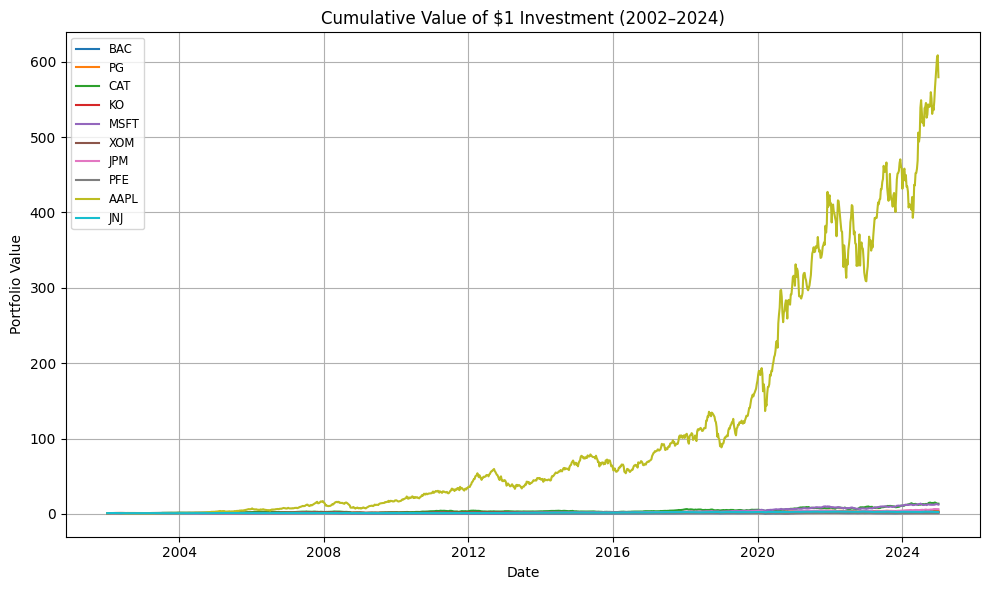

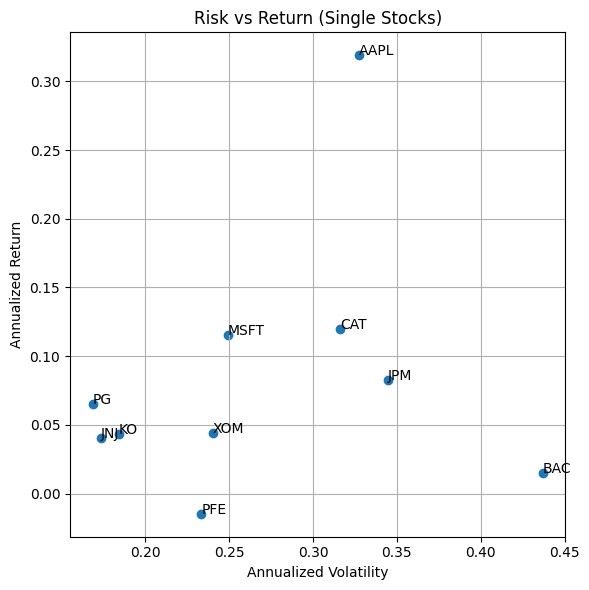

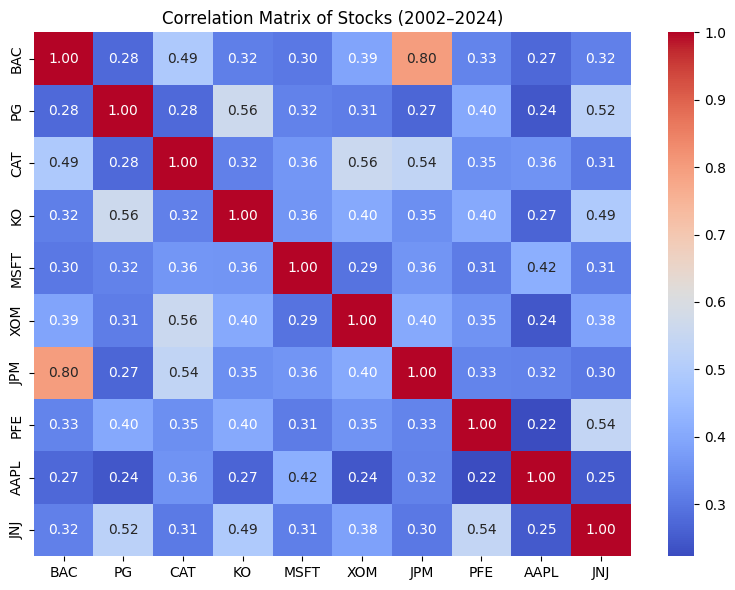

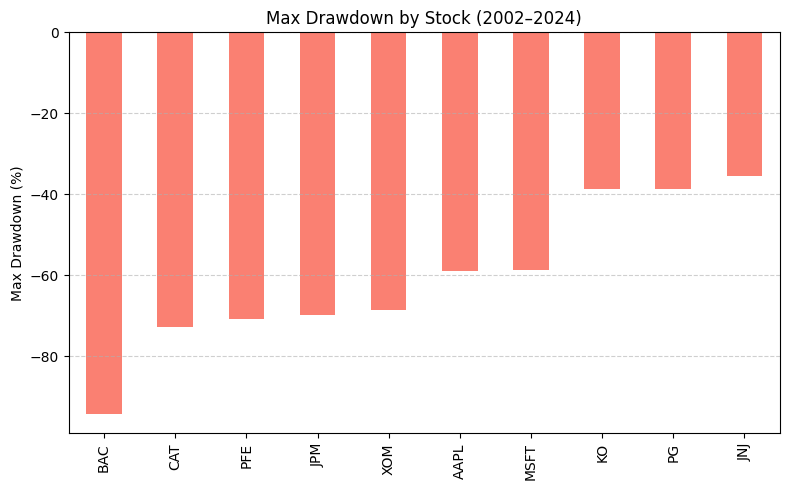

In [4]:
# ==========================================
# Part 2: Single Stock Performance Summary & Exploration
# ==========================================
print("Step 2: Computing single stock performance (2002-2024)...")

# Load returns for 2002-2024
returns = pd.read_csv(output_return_file, index_col='Date', parse_dates=True)
returns = returns.loc['2002-01-01':'2024-12-31']

# Compute cumulative returns
cum_returns = (1 + returns).cumprod()

# Compute summary statistics
n_years = (returns.index[-1] - returns.index[0]).days / 365.25
final_returns = cum_returns.iloc[-1] - 1
geom_annualized = (1 + final_returns) ** (1 / n_years) - 1
annualized_vol = returns.std() * np.sqrt(52)

def max_drawdown(series):
    cum = (1 + series).cumprod()
    peak = cum.cummax()
    dd = (cum / peak) - 1
    return dd.min()
max_drawdowns = returns.apply(max_drawdown)
VaR_95 = -returns.quantile(0.05)
VaR_99 = -returns.quantile(0.01)

# Structured summary table
results = pd.DataFrame({
    'Cumulative Return': final_returns,
    'Annualized Return': geom_annualized,
    'Annualized Volatility': annualized_vol,
    'Max Drawdown': max_drawdowns,
    'VaR (95%)': VaR_95,
    'VaR (99%)': VaR_99
})

# Formatted display
formatted = results.applymap(lambda x: f"{x*100:.2f}%")
print("\n--- Single Stock Performance Table (2002–2024) ---")
display(formatted)

# --- 1. Cumulative return curve for all stocks ---
plt.figure(figsize=(10, 6))
for stock in cum_returns.columns:
    plt.plot(cum_returns.index, cum_returns[stock], label=stock)
plt.title("Cumulative Value of $1 Investment (2002–2024)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2. Risk vs Return Scatter Plot (Single Stocks) ---
plt.figure(figsize=(6, 6))
plt.scatter(results['Annualized Volatility'], results['Annualized Return'])
for ticker in results.index:
    plt.text(results.loc[ticker, 'Annualized Volatility'], results.loc[ticker, 'Annualized Return'], ticker)
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Risk vs Return (Single Stocks)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3. Correlation Matrix Heatmap (Single Stocks) ---
import seaborn as sns
correlation_matrix = returns.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Stocks (2002–2024)")
plt.tight_layout()
plt.show()

# --- 4. Max Drawdown Bar Plot (Single Stocks) ---
drawdown_percent = results['Max Drawdown'].sort_values() * 100  # Already in -0.xx format
plt.figure(figsize=(8, 5))
drawdown_percent.plot(kind='bar', color='salmon')
plt.title("Max Drawdown by Stock (2002–2024)")
plt.ylabel("Max Drawdown (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [6]:
# ==========================================
# Part 3: Rolling MVO Optimization (Window/Period)
# ==========================================
print("Step 3: Rolling MVO Portfolio Optimization...")

returns = pd.read_csv(output_return_file, index_col=0, parse_dates=True)
weekly_returns_df = returns
returns = returns.loc['2000-01-01':'2024-12-31']
window_size = 104   # weeks
holding_period = 52 # weeks
risk_free_rate = 0.02 / 52  # weekly risk-free rate

tickers = returns.columns.tolist()
weights_df = pd.DataFrame(index=tickers)
risk_metrics_df = pd.DataFrame(index=tickers)

for start in range(0, len(returns) - window_size - holding_period, holding_period):
    window_data = returns.iloc[start:start + window_size]
    mean_returns = window_data.mean()
    cov_matrix = window_data.cov()
    corr_matrix = window_data.corr()
    window_start = window_data.index.min()
    window_end = window_data.index.max()
    period_name = f"{window_start.date()} to {window_end.date()}"
    def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        portfolio_return = np.sum(mean_returns * weights) * 52
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(52)
        return -(portfolio_return - risk_free_rate) / portfolio_volatility
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 0.3) for _ in range(num_assets))
    initial_weights = num_assets * [1. / num_assets, ]
    optimized = minimize(neg_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix, risk_free_rate),
                         method='SLSQP', bounds=bounds, constraints=constraints)
    weights_df[period_name] = optimized.x

    print(f"\n--- Covariance Matrix ({window_start} ~ {window_end}) ---\n", cov_matrix.round(4))
    print(f"\n--- Correlation Matrix ({window_start} ~ {window_end}) ---\n", corr_matrix.round(4))

    VaR_95 = window_data.quantile(0.05)
    VaR_99 = window_data.quantile(0.01)
    annualized_return = window_data.mean() * 52
    annualized_volatility = window_data.std() * np.sqrt(52)
    risk_metrics_df[f"{period_name} Return"] = annualized_return.apply(lambda x: f"{x * 100:.2f}%")
    risk_metrics_df[f"{period_name} Volatility"] = annualized_volatility.apply(lambda x: f"{x * 100:.2f}%")
    risk_metrics_df[f"{period_name} VaR 95%"] = VaR_95.apply(lambda x: f"{x * 100:.2f}%")
    risk_metrics_df[f"{period_name} VaR 99%"] = VaR_99.apply(lambda x: f"{x * 100:.2f}%")

weights_df_pct = weights_df.applymap(lambda x: f"{x * 100:.2f}%")
print("\n--- Rolling Window Optimized Weights (percent) ---")
display(weights_df_pct)


Step 3: Rolling MVO Portfolio Optimization...

--- Covariance Matrix (2000-01-09 00:00:00 ~ 2001-12-30 00:00:00) ---
          BAC      PG     CAT      KO    MSFT     XOM     JPM     PFE    AAPL  \
BAC   0.0032  0.0005  0.0013  0.0004  0.0006  0.0002  0.0025  0.0003  0.0013   
PG    0.0005  0.0037  0.0007  0.0010 -0.0004  0.0004  0.0003  0.0004 -0.0011   
CAT   0.0013  0.0007  0.0027  0.0004  0.0001  0.0006  0.0012  0.0003  0.0007   
KO    0.0004  0.0010  0.0004  0.0022 -0.0000  0.0005  0.0003  0.0002 -0.0004   
MSFT  0.0006 -0.0004  0.0001 -0.0000  0.0044  0.0003  0.0013  0.0000  0.0025   
XOM   0.0002  0.0004  0.0006  0.0005  0.0003  0.0012  0.0003  0.0005  0.0000   
JPM   0.0025  0.0003  0.0012  0.0003  0.0013  0.0003  0.0040  0.0004  0.0016   
PFE   0.0003  0.0004  0.0003  0.0002  0.0000  0.0005  0.0004  0.0017 -0.0004   
AAPL  0.0013 -0.0011  0.0007 -0.0004  0.0025  0.0000  0.0016 -0.0004  0.0084   
JNJ   0.0001  0.0009  0.0005  0.0007 -0.0002  0.0004 -0.0000  0.0007 -0.0002   

 

/var/folders/72/17l24dnj3vvb497h_h9kf2z40000gn/T/ipykernel_50246/2096996495.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  weights_df_pct = weights_df.applymap(lambda x: f"{x * 100:.2f}%")


,2000-01-09 to 2001-12-30,2001-01-07 to 2002-12-29,2002-01-06 to 2003-12-28,2003-01-05 to 2004-12-26,2004-01-04 to 2005-12-25,2005-01-02 to 2006-12-24,2006-01-01 to 2007-12-23,2006-12-31 to 2008-12-21,2007-12-30 to 2009-12-20,2008-12-28 to 2010-12-19,...,2012-12-23 to 2014-12-14,2013-12-22 to 2015-12-13,2014-12-21 to 2016-12-11,2015-12-20 to 2017-12-10,2016-12-18 to 2018-12-09,2017-12-17 to 2019-12-08,2018-12-16 to 2020-12-06,2019-12-15 to 2021-12-05,2020-12-13 to 2022-12-04,2021-12-12 to 2023-12-03
BAC,30.00%,30.00%,27.84%,21.70%,28.20%,0.00%,0.00%,0.00%,0.00%,0.00%,...,11.04%,0.00%,10.62%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
PG,0.00%,30.00%,30.00%,19.52%,27.03%,28.11%,26.82%,30.00%,0.00%,15.55%,...,26.46%,0.00%,0.00%,0.00%,3.12%,30.00%,25.53%,0.00%,0.00%,0.00%
CAT,10.00%,0.00%,30.00%,11.98%,0.00%,0.00%,0.00%,0.00%,0.00%,6.08%,...,0.00%,0.00%,0.00%,30.00%,3.09%,0.00%,14.47%,16.75%,0.00%,21.98%
KO,0.00%,0.00%,12.16%,0.00%,0.00%,13.41%,30.00%,10.00%,10.00%,30.00%,...,0.00%,8.89%,0.00%,0.00%,19.33%,11.59%,0.00%,0.00%,18.14%,22.52%
MSFT,0.00%,17.92%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,15.18%,...,23.03%,30.00%,30.00%,21.79%,30.00%,30.00%,30.00%,30.00%,4.69%,25.50%
XOM,0.00%,0.00%,0.00%,22.04%,0.36%,26.69%,27.59%,30.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,30.00%,30.00%
JPM,0.00%,0.00%,0.00%,0.00%,0.00%,5.77%,0.00%,0.00%,30.00%,0.00%,...,0.00%,1.11%,30.00%,3.27%,0.00%,5.79%,0.00%,0.00%,0.00%,0.00%
PFE,30.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,24.39%,0.00%,0.00%,23.25%,17.17%,0.00%
AAPL,0.00%,0.00%,0.00%,24.76%,30.00%,26.02%,15.59%,30.00%,30.00%,30.00%,...,13.49%,30.00%,0.00%,14.95%,20.07%,22.61%,30.00%,30.00%,0.00%,0.00%
JNJ,30.00%,22.08%,0.00%,0.00%,14.42%,0.00%,0.00%,0.00%,30.00%,3.18%,...,25.97%,30.00%,29.38%,30.00%,0.00%,0.00%,0.00%,0.00%,30.00%,0.00%


Step 4: Backtesting rolling portfolio...

--- Portfolio Weekly Returns & Value (head) ---


,portfolio_value,portfolio_return
Date,,
2002-01-06,0.990071,-0.009929
2002-01-13,0.989793,-0.000281
2002-01-20,1.006237,0.016614
2002-01-27,1.000574,-0.005628
2002-02-03,0.978737,-0.021825



--- Weekly Stock Values (head) ---


,BAC,PG,CAT,KO,MSFT,XOM,JPM,PFE,AAPL,JNJ
Date,,,,,,,,,,
2002-01-06,0.286095,0.0,0.094356,0.0,5.803292e-16,1.870032e-16,0.0,0.309157,0.0,0.300464
2002-01-13,0.285625,0.0,0.090939,0.0,5.591802e-16,1.865175e-16,0.0,0.305301,0.0,0.308050
2002-01-20,0.297651,0.0,0.093019,0.0,5.397231e-16,1.902090e-16,0.0,0.317510,0.0,0.297472
2002-01-27,0.288256,0.0,0.093799,0.0,5.300791e-16,1.894318e-16,0.0,0.320964,0.0,0.297214
2002-02-03,0.284685,0.0,0.090048,0.0,5.129907e-16,1.859832e-16,0.0,0.309880,0.0,0.293498


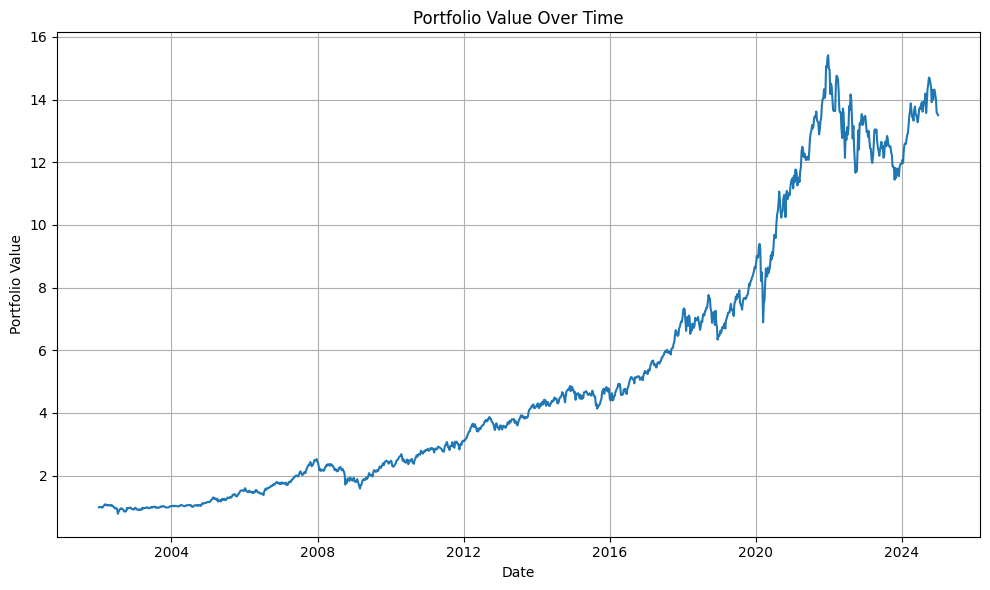

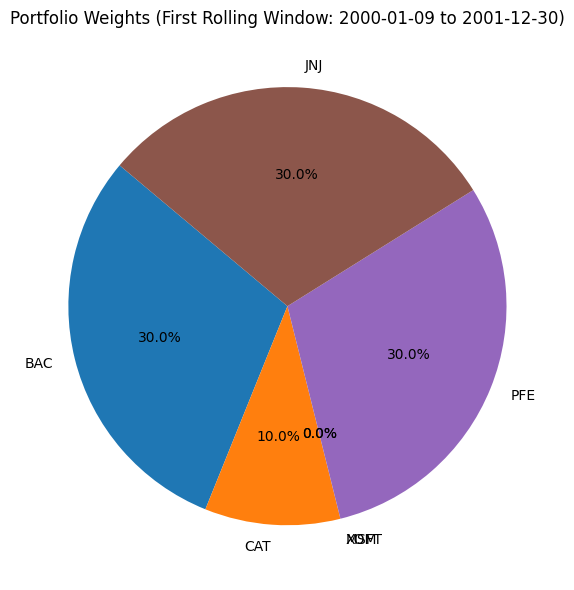

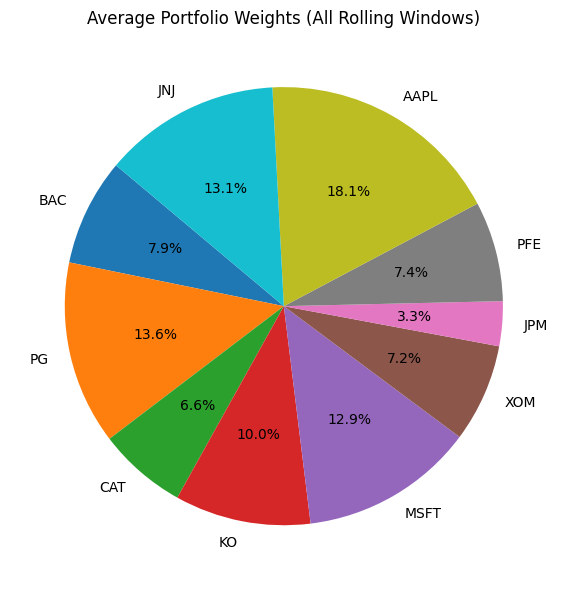

In [ ]:
# ==========================================
# Part 4: Backtesting Rolling Portfolio Performance
# ==========================================
print("Step 4: Backtesting rolling portfolio...")

periods = weights_df.columns.tolist()
label_end_dates = [pd.to_datetime(p.split(' to ')[1]) for p in periods]
prev_value = 1.0
return_results = []
stock_value_results = []

for i, col in enumerate(periods):
    start_date = label_end_dates[i]
    end_date = label_end_dates[i + 1] if i < len(periods) - 1 else weekly_returns_df.index.max()
    mask = (weekly_returns_df.index > start_date) & (weekly_returns_df.index <= end_date)
    period_returns = weekly_returns_df.loc[mask, weights_df.index]
    port_rets = period_returns.mul(weights_df[col], axis=1).sum(axis=1)
    port_values = prev_value * (1 + port_rets).cumprod()
    initial_stock_values = prev_value * weights_df[col]
    cum_stock_returns = (1 + period_returns).cumprod()
    stock_values = cum_stock_returns.mul(initial_stock_values, axis=1)
    df_ret = pd.DataFrame({'portfolio_value': port_values, 'portfolio_return': port_rets})
    return_results.append(df_ret)
    stock_value_results.append(stock_values)
    prev_value = port_values.iloc[-1]

combined_returns = pd.concat(return_results)
combined_stock_values = pd.concat(stock_value_results)
MVO_weekly_returns = combined_returns

print("\n--- Portfolio Weekly Returns & Value (head) ---")
display(combined_returns.head())

print("\n--- Weekly Stock Values (head) ---")
display(combined_stock_values.head())

# Portfolio value curve
plt.figure(figsize=(10, 6))
plt.plot(MVO_weekly_returns.index, MVO_weekly_returns['portfolio_value'], linewidth=1.5)
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Portfolio Weights Pie Chart: First Rolling Window ---
first_period = weights_df.columns[0]
plt.figure(figsize=(6, 6))
weights_df[first_period][weights_df[first_period]>0].plot.pie(
    autopct='%1.1f%%', startangle=140, ylabel=''
)
plt.title(f"Portfolio Weights (First Rolling Window: {first_period})")
plt.tight_layout()
plt.show()

# --- Portfolio Weights Pie Chart: Average Over All Windows ---
mean_weights = weights_df.mean(axis=1)
plt.figure(figsize=(6, 6))
mean_weights[mean_weights>0].plot.pie(
    autopct='%1.1f%%', startangle=140, ylabel=''
)
plt.title("Average Portfolio Weights (All Rolling Windows)")
plt.tight_layout()
plt.show()

In [6]:
# ==========================================
# Part 5: Performance Metrics Summary
# ==========================================
print("Step 5: Portfolio performance metrics...")

df = MVO_weekly_returns
initial_value = df['portfolio_value'].iloc[0]
final_value = df['portfolio_value'].iloc[-1]
n_weeks = len(df)
cumulative_return = final_value / initial_value - 1
annualized_return = (final_value / initial_value) ** (52 / n_weeks) - 1
annualized_vol = df['portfolio_return'].std() * np.sqrt(52)
running_max = df['portfolio_value'].cummax()
max_drawdown = (df['portfolio_value'] / running_max - 1).min()
var_95 = -np.percentile(df['portfolio_return'], 5)
var_99 = -np.percentile(df['portfolio_return'], 1)
sharpe_ratio = annualized_return / annualized_vol

metrics = pd.DataFrame({
    'Metric': [
        'Cumulative Return', 'Annualized Return', 'Annualized Volatility',
        'Max Drawdown', 'VaR (95%)', 'VaR (99%)', 'Sharpe Ratio'
    ],
    'Value': [
        cumulative_return, annualized_return, annualized_vol,
        max_drawdown, var_95, var_99, sharpe_ratio
    ]
})
metrics['Value'] = metrics.apply(
    lambda row: f"{row['Value']*100:.2f}%" if row['Metric'] != 'Sharpe Ratio' else f"{row['Value']:.2f}",
    axis=1
)
print("\n--- Portfolio Performance Summary ---")
display(metrics)

Step 5: Portfolio performance metrics...

--- Portfolio Performance Summary ---


,Metric,Value
0,Cumulative Return,1263.75%
1,Annualized Return,11.99%
2,Annualized Volatility,17.40%
3,Max Drawdown,-37.24%
4,VaR (95%),3.41%
5,VaR (99%),5.33%
6,Sharpe Ratio,0.69


In [7]:
# ==========================================
# Part 6: Extended Risk Metrics (CVaR, Sortino, Calmar)
# ==========================================
print("Step 6: Extended risk metrics (CVaR, Sortino, Calmar)...")

rets = df['portfolio_return']
cvar95 = -rets[rets <= np.percentile(rets, 5)].mean()
downside_std = rets[rets < 0].std() * np.sqrt(52)
sortino = annualized_return / downside_std
calmar = annualized_return / abs(max_drawdown)

ext_metrics = pd.DataFrame({
    'Metric': ['CVaR (95%)', 'Sortino Ratio', 'Calmar Ratio'],
    'Value':  [cvar95, sortino, calmar]
})
ext_metrics['Value'] = ext_metrics.apply(
    lambda x: f"{x.Value*100:.2f}%" if 'CVaR' in x.Metric else f"{x.Value:.2f}", axis=1
)
print("\n--- Extended Risk Metrics ---")
display(ext_metrics)

Step 6: Extended risk metrics (CVaR, Sortino, Calmar)...

--- Extended Risk Metrics ---


,Metric,Value
0,CVaR (95%),5.33%
1,Sortino Ratio,0.94
2,Calmar Ratio,0.32


Step 7: Turnover and transaction cost analysis...

--- Turnover & Transaction Cost per Rebalance ---


,Period,Turnover,CostRate,Cost
0,2001-01-07 to 2002-12-29,47.92%,0.001,0.05%
1,2002-01-06 to 2003-12-28,42.16%,0.001,0.04%
2,2003-01-05 to 2004-12-26,46.80%,0.001,0.05%
3,2004-01-04 to 2005-12-25,33.66%,0.001,0.03%
4,2005-01-02 to 2006-12-24,46.59%,0.001,0.05%
5,2006-01-01 to 2007-12-23,17.49%,0.001,0.02%
6,2006-12-31 to 2008-12-21,20.00%,0.001,0.02%
7,2007-12-30 to 2009-12-20,60.00%,0.001,0.06%
8,2008-12-28 to 2010-12-19,56.82%,0.001,0.06%
9,2009-12-27 to 2011-12-18,18.36%,0.001,0.02%


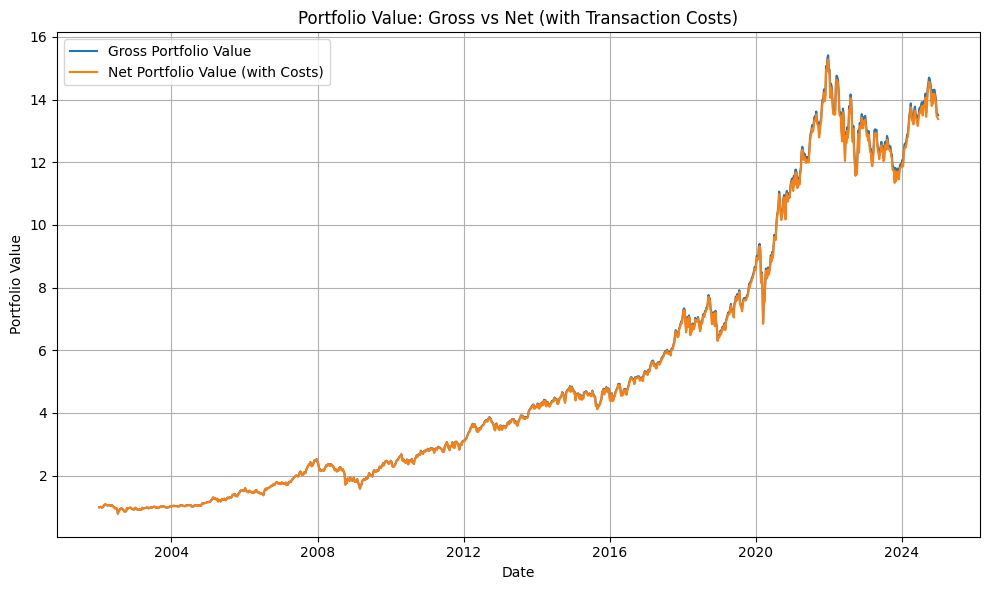


--- Gross vs Net Performance Comparison ---


,Metric,Gross,Net
0,Cumulative Return,1263.75%,1252.21%
1,Annualized Return,11.99%,11.95%
2,Annualized Volatility,17.40%,17.40%
3,Max Drawdown,-37.24%,-37.29%
4,VaR (95%),3.41%,3.41%
5,Sharpe Ratio,0.69,0.69


In [8]:
# ==========================================
# Part 7: Turnover & Transaction Cost Analysis
# ==========================================
print("Step 7: Turnover and transaction cost analysis...")

weights = weights_df
periods = weights.columns.tolist()
turns = []
cost_rate = 0.001  # 0.1% per rebalance

for i in range(1, len(periods)):
    w0 = weights[periods[i-1]].values
    w1 = weights[periods[i]].values
    turnover = np.sum(np.abs(w1 - w0)) / 2
    cost = turnover * cost_rate
    turns.append({
        "Period": periods[i],
        "Turnover": turnover,
        "CostRate": cost_rate,
        "Cost": cost
    })

turn_df = pd.DataFrame(turns)
turn_df_formatted = turn_df.copy()
turn_df_formatted["Turnover"] = turn_df["Turnover"].map(lambda x: f"{x*100:.2f}%")
turn_df_formatted["Cost"] = turn_df["Cost"].map(lambda x: f"{x*100:.2f}%")
print("\n--- Turnover & Transaction Cost per Rebalance ---")
display(turn_df_formatted)

# Apply transaction cost
combined = MVO_weekly_returns
gross_returns = combined["portfolio_return"]
gross_values = combined["portfolio_value"]
net_returns = gross_returns.copy()
label_end_dates = [pd.to_datetime(p.split(" to ")[1]) for p in periods]
for idx, row in turn_df.iterrows():
    rebalance_date = combined.index[combined.index > label_end_dates[idx]][0]
    net_returns.loc[rebalance_date] -= row["Cost"]
net_values = (1 + net_returns).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(combined.index, gross_values, label="Gross Portfolio Value", linewidth=1.5)
plt.plot(net_values.index, net_values, label="Net Portfolio Value (with Costs)", linewidth=1.5)
plt.title("Portfolio Value: Gross vs Net (with Transaction Costs)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gross vs Net Performance Table
def perf_stats(values, returns):
    initial, final = values.iloc[0], values.iloc[-1]
    cum_ret = final/initial - 1
    ann_ret = (final/initial)**(52/len(returns)) - 1
    ann_vol = returns.std()*np.sqrt(52)
    max_dd = (values/values.cummax() - 1).min()
    var95 = -np.percentile(returns, 5)
    sharpe = ann_ret/ann_vol
    return cum_ret, ann_ret, ann_vol, max_dd, var95, sharpe
gross_stats = perf_stats(gross_values, gross_returns)
net_stats = perf_stats(net_values, net_returns)
metrics = [
    "Cumulative Return", "Annualized Return", "Annualized Volatility", "Max Drawdown", "VaR (95%)", "Sharpe Ratio"
]
comp_df = pd.DataFrame({
    "Metric": metrics,
    "Gross": [f"{x*100:.2f}%" if i!=5 else f"{x:.2f}" for i,x in enumerate(gross_stats)],
    "Net": [f"{x*100:.2f}%" if i!=5 else f"{x:.2f}" for i,x in enumerate(net_stats)]
})
print("\n--- Gross vs Net Performance Comparison ---")
display(comp_df)


In [9]:
# ==========================================
# Part 8: Parameter Sensitivity Analysis (Window/Holding)
# ==========================================
print("Step 8: Parameter sensitivity analysis...")

window_list = [52, 104, 156]
holding_list = [26, 52]
tickers = returns.columns.tolist()
sens_results = []
for ws in window_list:
    for hp in holding_list:
        rets_list = []
        for start in range(0, len(returns) - ws - hp + 1, hp):
            window_data = returns.iloc[start:start+ws]
            mu = window_data.mean()
            cov = window_data.cov()
            def neg_sharpe(w):
                port_ret = (mu @ w) * 52
                port_vol = np.sqrt(w.T @ cov.values @ w) * np.sqrt(52)
                return -port_ret / port_vol
            cons = ({'type':'eq','fun':lambda w: np.sum(w)-1},)
            bounds = tuple((0,0.3) for _ in tickers)
            w0 = np.repeat(1/len(tickers), len(tickers))
            res = minimize(neg_sharpe, w0, bounds=bounds, constraints=cons, method='SLSQP')
            w_opt = res.x
            period = returns.iloc[start:start+ws+hp]
            port_series = period.mul(w_opt, axis=1).sum(axis=1)
            rets_list.append(port_series)
        port_ret_all = pd.concat(rets_list)
        cum_ret = (1 + port_ret_all).cumprod().iloc[-1] - 1
        ann_ret = (1 + cum_ret)**(52/len(port_ret_all)) - 1
        ann_vol = port_ret_all.std() * np.sqrt(52)
        sharpe = ann_ret / ann_vol
        sens_results.append({
            'Window (wks)': ws,
            'Holding (wks)': hp,
            'Ann_Return': ann_ret,
            'Ann_Volatility': ann_vol,
            'Sharpe_Ratio': sharpe
        })

sens_df = pd.DataFrame(sens_results)
sens_df['Ann_Return'] = sens_df['Ann_Return'].map(lambda x: f"{x*100:.2f}%")
sens_df['Ann_Volatility'] = sens_df['Ann_Volatility'].map(lambda x: f"{x*100:.2f}%")
sens_df['Sharpe_Ratio'] = sens_df['Sharpe_Ratio'].map(lambda x: f"{x:.2f}")
print("\n--- Parameter Sensitivity Analysis Table ---")
display(sens_df)

Step 8: Parameter sensitivity analysis...

--- Parameter Sensitivity Analysis Table ---


,Window (wks),Holding (wks),Ann_Return,Ann_Volatility,Sharpe_Ratio
0,52,26,23.47%,19.90%,1.18
1,52,52,19.59%,18.07%,1.08
2,104,26,21.98%,18.42%,1.19
3,104,52,19.43%,17.94%,1.08
4,156,26,21.29%,17.84%,1.19
5,156,52,20.30%,17.91%,1.13


Step 9: Backtesting during financial crises...

--- Crisis Backtest Results Table ---


,Crisis,Start Date,End Date,Trough Date,Trough Value,Recovery Date,Recovery Days
0,2008 Financial Crisis,2008-09-07,2009-08-30,2009-03-01,1.586375,2009-09-13,371
1,COVID‑19 Crash,2020-02-02,2020-05-31,2020-03-15,6.894672,2020-06-28,147


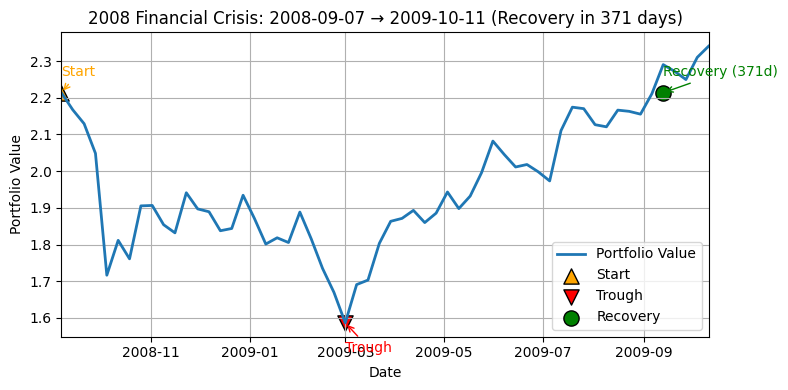

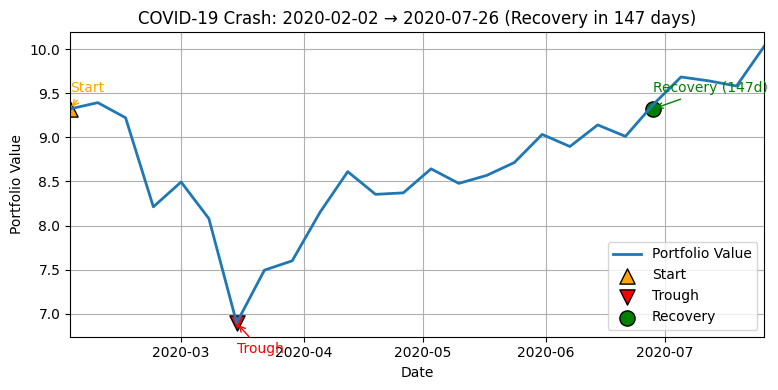

In [10]:
# ==========================================
# Part 9: Historical Crisis Backtest & Visualization
# ==========================================
print("Step 9: Backtesting during financial crises...")

df = MVO_weekly_returns
crises = {
    '2008 Financial Crisis': ('2008-09-01', '2009-09-01'),
    'COVID‑19 Crash': ('2020-02-01', '2020-06-01')
}
results = []
for name, (start, end) in crises.items():
    seg = df.loc[start:end]
    if seg.empty:
        continue
    v0 = seg['portfolio_value'].iloc[0]
    running_max = seg['portfolio_value'].cummax()
    dd = seg['portfolio_value']/running_max - 1
    trough_date = dd.idxmin()
    trough_val = seg.loc[trough_date, 'portfolio_value']
    post_trough = df.loc[trough_date:]
    rec_mask = post_trough['portfolio_value'] >= v0
    if rec_mask.any():
        recovery_date = rec_mask.idxmax()
        recovery_days = (recovery_date - seg.index[0]).days
    else:
        recovery_date, recovery_days = None, np.nan
    results.append({
        'Crisis': name,
        'Start Date': seg.index[0].date(),
        'End Date': seg.index[-1].date(),
        'Trough Date': trough_date.date(),
        'Trough Value': trough_val,
        'Recovery Date': recovery_date.date() if recovery_date else None,
        'Recovery Days': int(recovery_days) if not np.isnan(recovery_days) else None
    })
crisis_df = pd.DataFrame(results)
print("\n--- Crisis Backtest Results Table ---")
display(crisis_df)

for _, row in crisis_df.iterrows():
    name = row['Crisis']
    sd = pd.to_datetime(row['Start Date'])
    td = pd.to_datetime(row['Trough Date'])
    rd = pd.to_datetime(row['Recovery Date']) if row['Recovery Date'] else None
    days = row['Recovery Days']
    plot_end = (rd + pd.Timedelta(weeks=4)) if rd is not None else df.index[-1]
    seg_zoom = df.loc[sd:plot_end]
    plt.figure(figsize=(8,4))
    plt.plot(seg_zoom.index, seg_zoom['portfolio_value'], lw=2, label='Portfolio Value')
    v0 = df.loc[sd, 'portfolio_value']
    plt.scatter(sd, v0, color='orange', marker='^', s=120, edgecolor='k', label='Start')
    plt.annotate("Start", xy=(sd, v0), xytext=(sd, v0*1.02),
                 arrowprops=dict(arrowstyle="->", color='orange'), color='orange')
    plt.scatter(td, row['Trough Value'], color='red', marker='v', s=120, edgecolor='k', label='Trough')
    plt.annotate("Trough", xy=(td, row['Trough Value']), xytext=(td, row['Trough Value']*0.95),
                 arrowprops=dict(arrowstyle="->", color='red'), color='red')
    if rd is not None:
        plt.scatter(rd, v0, color='green', marker='o', s=120, edgecolor='k', label='Recovery')
        plt.annotate(f"Recovery ({days}d)", xy=(rd, v0), xytext=(rd, v0*1.02),
                     arrowprops=dict(arrowstyle="->", color='green'), color='green')
    plt.title(f"{name}: {sd.date()} → {plot_end.date()} (Recovery in {days} days)")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.xlim(sd, plot_end)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Step 10: Monte Carlo simulation for annual portfolio return distribution...

--- Monte Carlo Simulation of Annual Returns ---


,Statistic,Formatted
0,Mean,13.87%
1,Std,20.01%
2,5th %ile,-15.78%
3,50th %ile,12.13%
4,95th %ile,49.53%


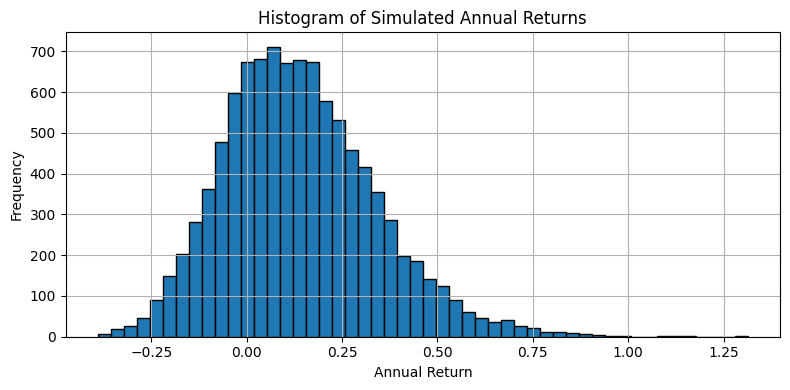

In [11]:
# ==========================================
# Part 10: Monte Carlo Simulation of Annual Returns
# ==========================================
print("Step 10: Monte Carlo simulation for annual portfolio return distribution...")

weekly_rets = MVO_weekly_returns['portfolio_return']
mu = weekly_rets.mean()
sigma = weekly_rets.std()
n_sim = 10000
n_weeks = 52

sim_rets = np.random.normal(mu, sigma, size=(n_sim, n_weeks))
sim_annual = np.prod(1 + sim_rets, axis=1) - 1

stats = pd.DataFrame({
    'Statistic': ['Mean', 'Std', '5th %ile', '50th %ile', '95th %ile'],
    'Value': [
        sim_annual.mean(),
        sim_annual.std(),
        np.percentile(sim_annual, 5),
        np.percentile(sim_annual, 50),
        np.percentile(sim_annual, 95)
    ]
})
stats['Formatted'] = stats['Value'].map(lambda x: f"{x*100:.2f}%")
print("\n--- Monte Carlo Simulation of Annual Returns ---")
display(stats[['Statistic','Formatted']])

plt.figure(figsize=(8,4))
plt.hist(sim_annual, bins=50, edgecolor='k')
plt.title("Histogram of Simulated Annual Returns")
plt.xlabel("Annual Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()